### Import packages

In [1]:
import sys
import pandas as pd
print(pd.__version__)
import os
import torch as th
print(th.backends.mps.is_available())
import numpy as np
import gymnasium as gym
print(gym.__version__)
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed

from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta

import stable_baselines3
print(stable_baselines3.__version__)



2.2.2
True
0.29.1
2.3.2


In [2]:
# Setting all debugging flags to False
DEBUG_MODE = False 
DEBUG_MODE_TRAINING = False 
DEBUG_MODE_REWARD = False  


### Hyperparameters

In [3]:
# Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000
BATCH_SIZE = 32
TARGET_UPDATE_INTERVAL = 100
EPSILON_START = 1.0
EPSILON_MIN = 0.005
EPSILON_DECAY_RATE = 0.0001
MAX_TIMESTEPS = 500         # maximum number of timesteps per episode (not relevant here)


N_EPISODES = 250           # number of episodes PER TRAINING SCENARIO
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256]) # hidden layer sizes



TRAINING_FOLDERS_PATH = '../data/Training-10-days/'


device = th.device('mps' if th.backends.mps.is_available() else 'cpu')



# Verify folders exists
if not os.path.exists(TRAINING_FOLDERS_PATH):
    raise FileNotFoundError(f'Training folder not found at {TRAINING_FOLDERS_PATH}')

# print all folders in the training folder
training_folders = []
for folder in os.listdir(TRAINING_FOLDERS_PATH):
    if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder)):
        training_folders.append(folder)

num_days_trained_on = N_EPISODES * len(training_folders)
print(f'Training on {num_days_trained_on} days of data ({N_EPISODES} episodes of {len(training_folders)} scenarios)')

model_name = 'dqn_' + str(num_days_trained_on) + "d_" + str(len(training_folders)) + "u"
print('Model name:', model_name)
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = '../trained_models/' + model_name + '-' + model_version + '.zip'

print('Model will be saved to:', MODEL_SAVE_PATH)

Training on 2500 days of data (250 episodes of 10 scenarios)
Model name: dqn_2500d_10u
Model will be saved to: ../trained_models/dqn_2500d_10u-2.zip


# Reinforcement Learning

## Environment

In [4]:
from src.environment import AircraftDisruptionEnv

## Training

In [5]:
rewards = []
epsilon_values = []
total_timesteps = 0
action_sequences = {os.path.join(TRAINING_FOLDERS_PATH, folder): {"best_actions": [], "best_reward": float('-inf'),
                                                                  "worst_actions": [], "worst_reward": float('inf')} 
                    for folder in training_folders}


def train_dqn_agent():
    # List all the scenario folders in Data/Training
    scenario_folders = [os.path.join(TRAINING_FOLDERS_PATH, folder) for folder in os.listdir(TRAINING_FOLDERS_PATH) if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))]
    
    total_timesteps = 0
    epsilon = EPSILON_START

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            if DEBUG_MODE_TRAINING:
                print(f"Training on scenario {scenario_folder}")
            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)

            # Extract necessary data for the environment
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Initialize the environment with the current scenario
            env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
            env = DummyVecEnv([lambda: env])

            # Initialize the DQN model with the custom policy and feature extractor
            model = DQN(
                policy='MlpPolicy',
                env=env,
                learning_rate=LEARNING_RATE,
                gamma=GAMMA,
                buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE,
                target_update_interval=TARGET_UPDATE_INTERVAL,
                verbose=1,
                policy_kwargs=NEURAL_NET_STRUCTURE,
                device='cpu'
            )

            # Reset the environment
            obs = env.reset()

            done = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done and timesteps < MAX_TIMESTEPS:
                obs_input = obs[0]
                model.exploration_rate = epsilon
                action, _ = model.predict(obs, deterministic=False)

                action = np.array([action])  # Wrap action in an array
                result = env.step(action)


                obs, reward, done, info = result
                terminated = done  # Old-style "done" flag
                truncated = False

                # Store the action
                action_sequence.append(action[0])

                # Accumulate the reward
                total_reward += reward[0]

                # Update epsilon (exploration rate)
                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                epsilon_values.append(epsilon)

                timesteps += 1
                total_timesteps += 1

            # Store the total reward for the episode with the scenario specified
            rewards.append((episode, scenario_folder, total_reward))

            # Update the worst action sequence if the current total reward is worse (lower)
            if total_reward < action_sequences[scenario_folder]["worst_reward"]:
                action_sequences[scenario_folder]["worst_actions"] = action_sequence
                action_sequences[scenario_folder]["worst_reward"] = total_reward
                

            # Update the best action sequence if the current total reward is better (higher)
            if total_reward > action_sequences[scenario_folder]["best_reward"]:
                action_sequences[scenario_folder]["best_actions"] = action_sequence
                action_sequences[scenario_folder]["best_reward"] = total_reward

            

            print(f"Episode {episode}, Scenario {scenario_folder}, Total Reward: {total_reward}")

    # Save the model after training
    model.save(MODEL_SAVE_PATH)

# Run the training process
train_dqn_agent()

for scenario, data in action_sequences.items():
    print(f"Scenario: {scenario}, Worst Reward: {data['worst_reward']}, Best Reward: {data['best_reward']}")
    print(f"Worst Action Sequence: {data['worst_actions']}")
    print(f"Best Action Sequence: {data['best_actions']}")
    
    # Save the action sequences to a CSV file
    save_best_and_worst_to_csv(scenario, MODEL_SAVE_PATH, data['worst_actions'], data['best_actions'], data['worst_reward'], data['best_reward'])


Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_03, Total Reward: 2831.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_04, Total Reward: 2354.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_05, Total Reward: 2317.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_02, Total Reward: 2380.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_10, Total Reward: 1741.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_09, Total Reward: 1792.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_07, Total Reward: 1684.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_01, Total Reward: 2615.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_06, Total Reward: 1791.0
Using cpu device
Episode 0, Scenario ../data/Training-10-days/Scenario_08, Total Reward: 1200.0
Using cpu device
Episode 1, Scenario ../

Trained on 10 days of data (10 unique scenarios)


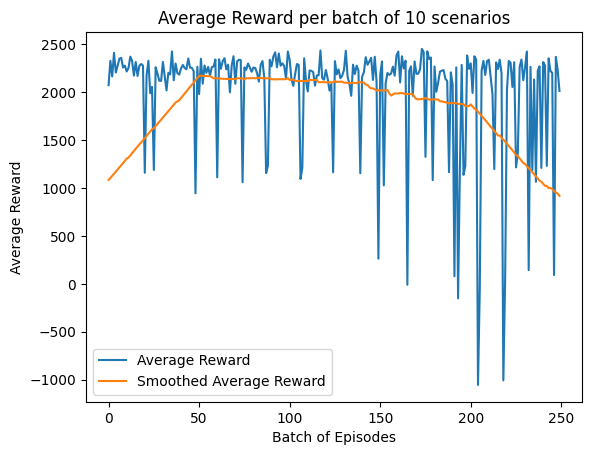

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated input
num_days_trained_on = 10  # Example value, set this to the actual number of days
rewards_per_day = len(rewards) // num_days_trained_on  # Assuming rewards are split evenly per day

# Print out the structure of the rewards list
print(f"Trained on {num_days_trained_on} days of data ({len(training_folders)} unique scenarios)")

avg_rewards = []

# amount of scenarios:
num_scenarios = len(training_folders)

# Average reward for every iteration of the scenarios
for i in range(0, len(rewards), len(training_folders)):
    avg_rewards.append(np.mean([reward for _, _, reward in rewards[i:i+num_scenarios]]))

# Smooth the average rewards with trailing window
window = 100

# Compute trailing average
smoothed_avg_rewards = np.convolve(avg_rewards, np.ones(window)/window, mode='same')

# Plot the average rewards over the episodes
plt.plot(range(len(avg_rewards)), avg_rewards, label='Average Reward')
plt.plot(range(len(smoothed_avg_rewards)), smoothed_avg_rewards, label='Trailing Smoothed Average Reward')
plt.legend(['Average Reward', 'Smoothed Average Reward'])
plt.xlabel('Batch of Episodes')
plt.ylabel('Average Reward')
plt.title(f'Average Reward per batch of {num_scenarios} scenarios')
plt.show()


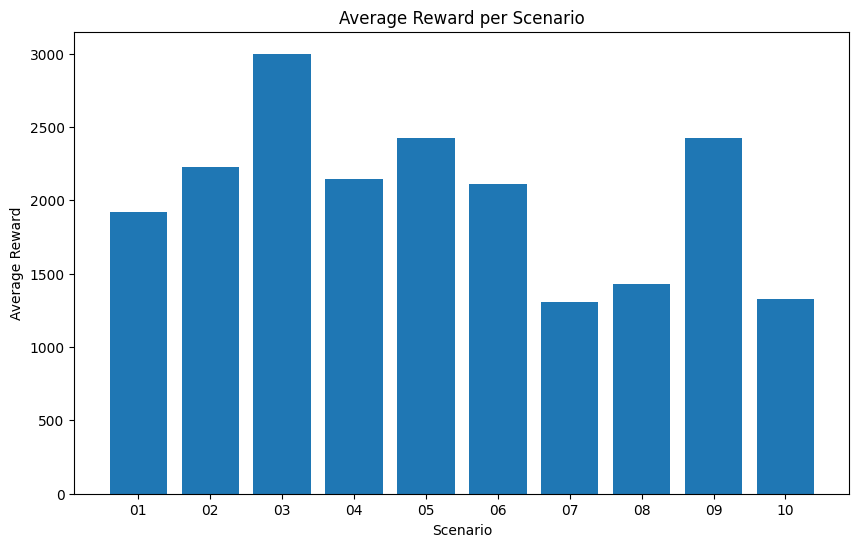

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize a dictionary to store rewards for each scenario
scenario_rewards = defaultdict(list)

# Iterate through the rewards list and group by scenario (last two characters)
for _, scenario, reward in rewards:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards[scenario_id].append(reward)

# Now, calculate the average reward for each scenario
avg_rewards_per_scenario = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards.items()}

# Sort the scenarios by their IDs (optional, to make sure they are ordered)
sorted_scenarios = sorted(avg_rewards_per_scenario.keys())

# Extract the sorted average rewards
sorted_avg_rewards = [avg_rewards_per_scenario[scenario] for scenario in sorted_scenarios]

# Plot a bar chart with scenarios on the x-axis and average rewards on the y-axis
plt.figure(figsize=(10, 6))
plt.bar(sorted_scenarios, sorted_avg_rewards)

# Adding labels and title
plt.xlabel('Scenario')
plt.ylabel('Average Reward')
plt.title('Average Reward per Scenario')

# Show plot
plt.show()


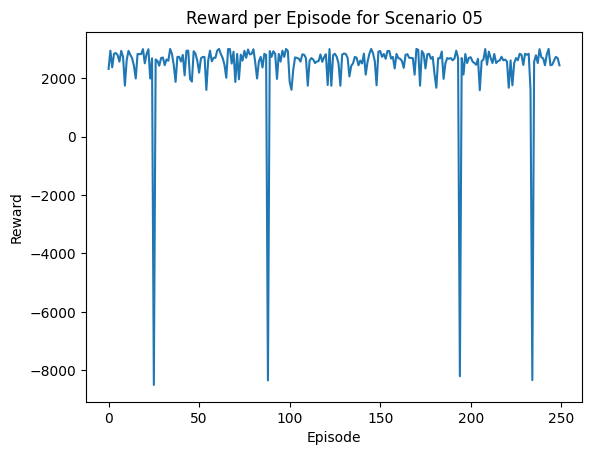

In [8]:
import numpy as np
import matplotlib.pyplot as plt

scenario_plot = '05'
# plot the average reward for scenario 1
plt.plot(scenario_rewards[scenario_plot])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode for Scenario ' + scenario_plot)
plt.show()


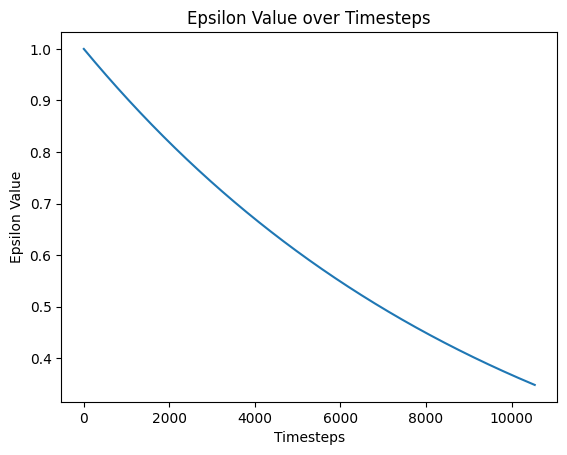

In [9]:

# Plot the epsilon values over the episodes
plt.plot(range(len(epsilon_values)), epsilon_values)
plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value over Timesteps')
plt.show()

In [10]:
3

3